In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pdpbox import pdp
import pickle
from sklearn.model_selection import train_test_split
import pandas as pd
from scipy.stats import chi2_contingency
from src import data_utils, model_utils


c:\Users\ibenn\Desktop\DSB\Year 2 HEC\Interpretable-jimams\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
raw_data = pd.read_csv("../data/data_clean.csv")
raw_data = raw_data[raw_data['birth date'] < 2020].copy()
# Load the model from the .pkl file
xgb_classifier = pickle.load(open("..\model\model.pkl", "rb"))


In [5]:
def replace_predict_chi_square(model, X, column, protected_column, value):
    X_copied = data_utils.preprocess_data(X)
    
    X_bis = X[X['birth date'] < 2020].copy()
    X_bis['age'] = X_bis['parole board interview date'] - X_bis['birth date']
    X_bis['jail duration'] = X_bis['parole board interview date'] - X_bis['year of entry']
    others_parole_type =  ['PIE', 'SP CONSDR', 'ECPDO', 'MEDICAL','RESCISSION', 'DEPORT']
    X_bis['parole board interview type'] = X['parole board interview type'].replace(others_parole_type, 'OTHERS').replace('SUPP MERIT', 'MERIT TIME').replace('PV REAPP', 'REAPPEAR')
    X_bis = X_bis.dropna(axis=0, subset=['crime 1 - class', 'parole eligibility date'])
    X_bis.drop(columns=['release date','birth date', 'year of entry'], inplace=True)

    unique_values = X_bis[column].unique()

    if X_bis[column].dtype in ['category', 'bool','object']:
        for unique_value in unique_values:
            
            if str(unique_value) != 'nan':
                X_copied[column + "_" + str(unique_value)] = (value == unique_value)
    else:
        X_copied[column] = value

    y_pred = model.predict(X_copied)
    contingency_table = pd.crosstab(X.loc[X_copied.index][protected_column], y_pred)
    chi2, p, a, b = chi2_contingency(contingency_table)
    return p

In [15]:
def predict_chi_square(model, X, column, protected_column):
    if X[column].dtype == 'float64':
        values = np.linspace(X[column].min(), X[column].max(), 50)
    else:
        values = X[column].unique()
    p_values = []
    values_final = []
    for value in values:
        if not(str(value) == 'nan'):
            p_value = replace_predict_chi_square(model, X, column, protected_column, value)
            p_values.append(p_value)
            values_final.append(value)

    plt.figure()
    plt.plot(values_final, p_values)
    plt.show()

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import chi2_contingency

def predict_multiple_chi_square(model, X, columns, protected_column):
    num_plots = len(columns)
    num_rows = np.ceil(num_plots / 2).astype(int)  # Calculate the number of rows needed
    fig, axs = plt.subplots(num_rows, 2, figsize=(15, num_rows * 5))  # Set up the plotting grid
    axs = axs.flatten()  # Flatten the array of axes for easy iteration

    for idx, column in enumerate(columns):
        if X[column].dtype == 'float64':
            values = np.linspace(X[column].min(), X[column].max(), 50)
        else:
            values = X[column].unique()

        p_values = []
        values_final = []
        for value in values:
            if not pd.isnull(value):  # More robust check for NaN
                p_value = replace_predict_chi_square(model, X, column, protected_column, value)
                p_values.append(p_value)
                values_final.append(value)

        # Plot on the appropriate subplot
        ax = axs[idx]
        ax.plot(values_final, p_values, marker='o')  # Plot the data
        ax.set_xlabel(column)  # Set the x-axis label to the name of the column
        ax.set_ylabel('p-value')  # Set the y-axis label to 'p-value'
        #ax.set_ylim(0, 1)  # Set the y-axis limits from 0 to 1
        ax.set_title('P-value by ' + column + 'for protected column ' + protected_column)  # Set the title of the subplot
        ax.axhline(y=0.05, color='r', linestyle='--')  # Add a horizontal red line at p-value = 0.05

    # Hide any unused subplots
    for ax in axs[num_plots:]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()




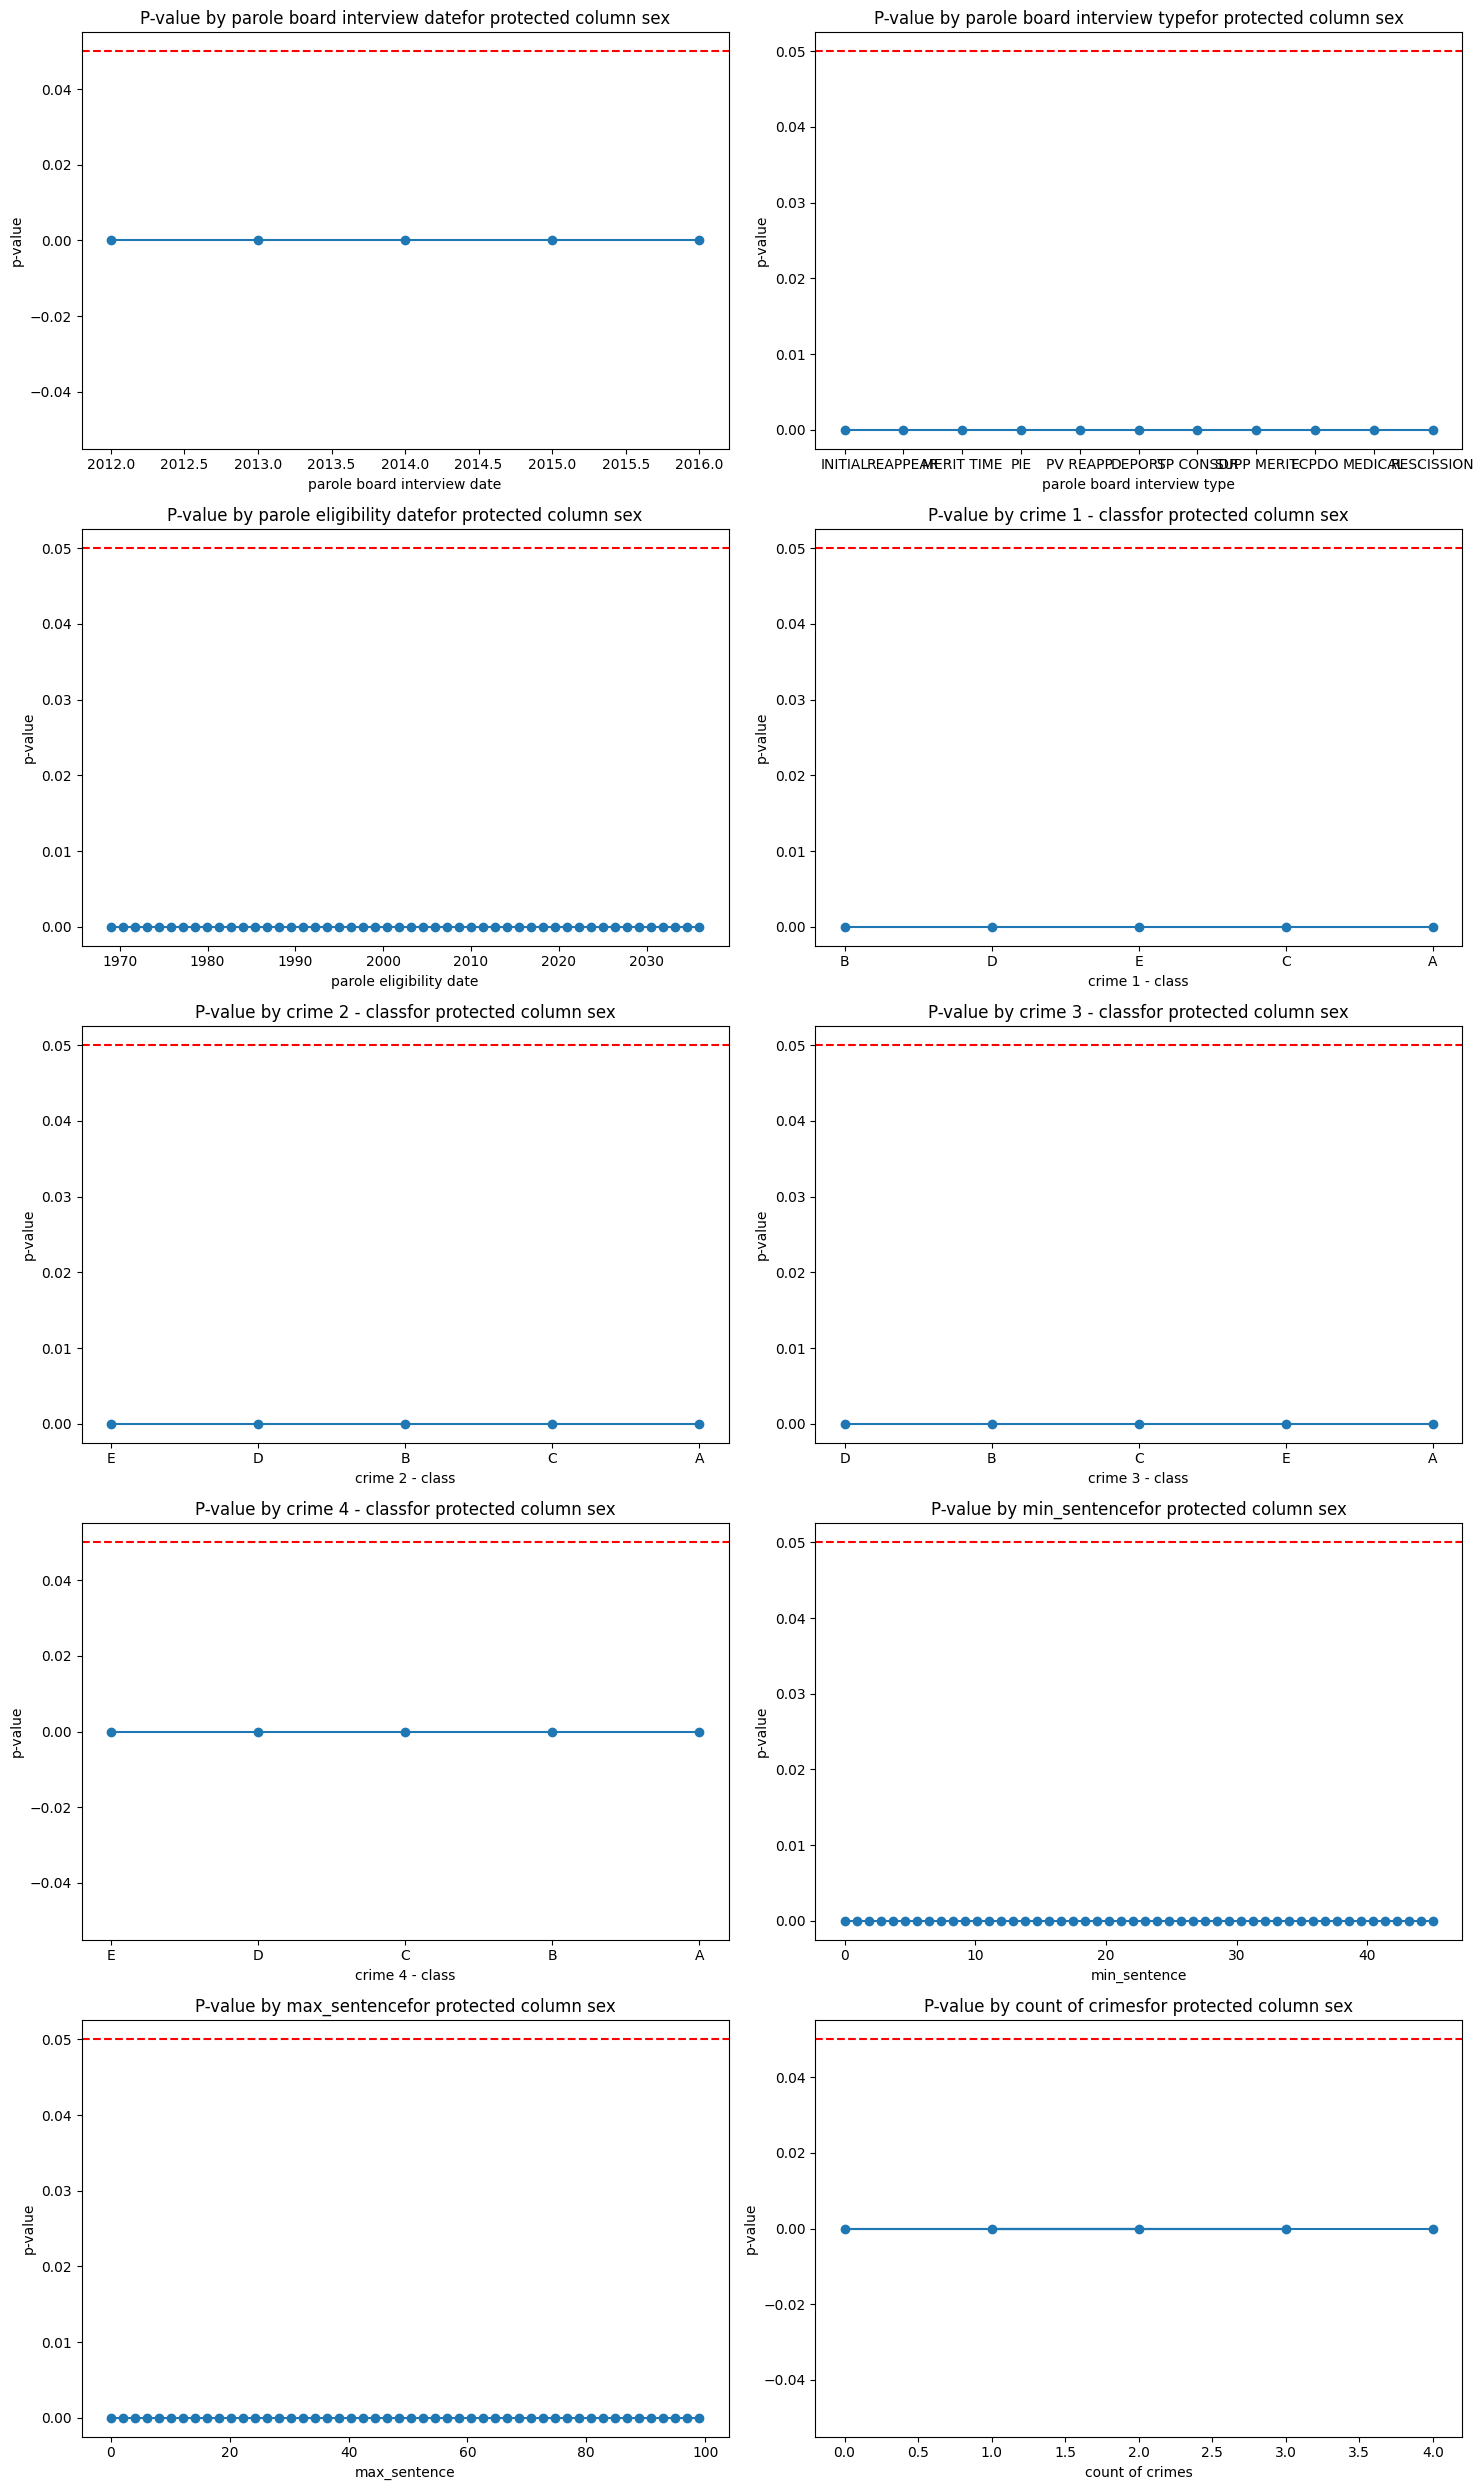

In [19]:
features = raw_data.drop(['race / ethnicity','sex','birth date', 'year of entry', 'release date','y'], axis=1).columns

predict_multiple_chi_square(xgb_classifier, raw_data.drop('y', axis=1), features, 'sex')